In [1]:
PATH = 'Trust_beysian.csv'

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import beta
from joblib import Parallel, delayed

In [4]:
# Define the payoff matrix for the game
payoffs = np.array(
    [
        [
            [50, 50],
            [50, 30],
        ],
        [
            [30, 50],
            [70, 70],
        ],
    ]
)

def get_payoff(player_id, p1_strategy, p2_strategy):
    return payoffs[p1_strategy, p2_strategy][player_id]

for i in range (2):
    for j in range(2):
        print(i, j, payoffs[i, j])
print(get_payoff(0, 1, 1))

0 0 [50 50]
0 1 [50 30]
1 0 [30 50]
1 1 [70 70]
70


In [5]:
def make_decision_based_on_trust(alpha, beta_param):
    # Draw a trust value from the Beta distribution
    trust = beta.rvs(alpha, beta_param)
    # Return 1 (collaborate) if a random number is less than the trust, else 0 (defect)
    return int(np.random.random() < trust)

print(make_decision_based_on_trust(1, 1))  # 1

1


In [9]:
def update_beta_params(alpha, beta_param,expected_payoff,payoff, max_payoff=70):
    
    if payoff >= expected_payoff:
        alpha += 0.5 * (payoff - expected_payoff) / max_payoff
    else:
        beta_param += 0.5 * (expected_payoff - payoff) / max_payoff
    return alpha, beta_param

print(update_beta_params(1, 1, 70, 70))  # (1, 1)

(1.0, 1)


In [11]:

def play_1_game_with_trust_and_beta(generator, alpha1, beta1, alpha2, beta2):
    
    # Players make decisions based on trust values
    p1_strategy = make_decision_based_on_trust(alpha1,beta1)
    p2_strategy = make_decision_based_on_trust(alpha2,beta2)
    
    # Get actual payoffs for both players
    p1_payoff = get_payoff(0, p1_strategy, p2_strategy)
    p2_payoff = get_payoff(1, p1_strategy, p2_strategy)
    
    # Expected payoffs if both players collaborate (used to scale trust updates)
    expected_payoff_p1 = get_payoff(0, 1, 1)  # Both collaborate
    expected_payoff_p2 = get_payoff(1, 1, 1)
    
    # Update Beta parameters (alpha and beta) based on success or failure
    alpha1, beta1 = update_beta_params(alpha1, beta1,p1_payoff,expected_payoff_p1)
    alpha2, beta2 = update_beta_params(alpha2, beta2, p2_payoff,expected_payoff_p2)

    return alpha1, beta1, alpha2, beta2
print(play_1_game_with_trust_and_beta(np.random, 1, 1, 1, 1))  # (1, 1, 1, 1)

(1.2857142857142856, 5, 1.1428571428571428, 3)


In [12]:
def run_game_get_final_trust(
    alpha1,
    beta1,
    alpha2,
    beta2,
    seed,
    num_games,
    early_stop=True,
    epsilon=10e-20,
):
    generator = np.random.default_rng(seed)

    # Initialize lists to store alpha, beta values at each step
    alpha1, beta1 = 1, 1 # Initial values
    alpha2, beta2 = 1, 1 # Initial values

    for i in range(num_games):
        old_alpha1, old_beta1 = alpha1, beta1
        old_alpha2, old_beta2 = alpha2, beta2

        alpha1, beta1, alpha2, beta2 = play_1_game_with_trust_and_beta(
            generator, alpha1, beta1, alpha2, beta2)

        # Calculate the total change in both players' Beta parameters
        delta = abs(alpha1 - old_alpha1) + abs(beta1 - old_beta1) + abs(alpha2 - old_alpha2) + abs(beta2 - old_beta2)
        
        # Early stopping condition if the change in parameters is below a threshold
        if early_stop and delta < epsilon:
            break

    # Return the final values of alpha and beta
    return alpha1, beta1, alpha2, beta2
print(run_game_get_final_trust(1, 1, 1, 1, 0, 1000))  # (1, 1, 1, 1)

(1.1428571428571428, 1, 1.1428571428571428, 1)


In [13]:
def compute_game(alpha1, beta1, alpha2, beta2, seed):
    try:
        # Get the final alpha and beta values after running the game
        final_alpha1, final_beta1, final_alpha2, final_beta2 = run_game_get_final_trust(
            alpha1,
            beta1,
            alpha2,
            beta2,
            seed=seed,
            num_games=3000,
            early_stop=True,
            epsilon=10e-20,
        )
        # Print the final alpha and beta values for both players
        print(f"Final Alpha1: {final_alpha1}, Final Beta1: {final_beta1}")
        print(f"Final Alpha2: {final_alpha2}, Final Beta2: {final_beta2}")
        
        return [
            seed,
            alpha1,
            beta1,
            alpha2,
            beta2,
            final_alpha1,
            final_beta1,
            final_alpha2,
            final_beta2,
        ]
    except Exception as e:
        return None


# Example: Running one game to print the final alpha and beta values
compute_game(1, 1, 1, 1, seed=42)




Final Alpha1: 1.9999999999999996, Final Beta1: 1
Final Alpha2: 1.9999999999999996, Final Beta2: 1


[42, 1, 1, 1, 1, 1.9999999999999996, 1, 1.9999999999999996, 1]

In [14]:
# Run simulations for various initial alpha and beta parameters (starting with 1, 1 which represents uniform distribution)
results = Parallel(-1)(
    delayed(compute_game)(init_alpha1, init_beta1, init_alpha2, init_beta2, seed)
    for init_alpha1, init_beta1 in zip(np.arange(0, 10, 1), np.arange(0, 10, 1))
    for init_alpha2, init_beta2 in zip(np.arange(0, 10, 1), np.arange(0, 10, 1))
    for seed in range(10)
)

# Store results in a DataFrame and save to CSV
df = pd.DataFrame(results, columns=[
            "seed",
            "init_alpha1",
            "init_beta1",
            "init_alpha2",
            "init_beta2",
            "final_alpha1",
            "final_beta1",
            "final_alpha2",
            "final_beta2",
        ])

# Save results to a CSV file (replace PATH with your desired file path)
df.to_csv(PATH)

# Display DataFrame
display(df)

,seed,init_alpha1,init_beta1,init_alpha2,init_beta2,final_alpha1,final_beta1,final_alpha2,final_beta2
0,0,0,0,0,0,1.000000,1,1.000000,1
1,1,0,0,0,0,1.000000,1,1.000000,1
2,2,0,0,0,0,1.000000,1,1.000000,1
3,3,0,0,0,0,1.714286,1,1.857143,1
4,4,0,0,0,0,1.142857,1,1.142857,1
...,...,...,...,...,...,...,...,...,...
995,5,9,9,9,9,1.285714,1,1.571429,1
996,6,9,9,9,9,1.000000,1,1.000000,1
997,7,9,9,9,9,1.571429,1,1.285714,1
998,8,9,9,9,9,1.714286,1,1.714286,1


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the DataFrame (already created from your previous results)
# If you need to load it again, use: df = pd.read_csv(PATH)

# Heatmap for final_alpha1 values based on init_alpha1 and init_beta1
heatmap_data_alpha1 = df.pivot_table(index="init_alpha1", columns="init_beta1", values="final_alpha1", aggfunc="mean")

# Heatmap for final_beta1 values based on init_alpha1 and init_beta1
heatmap_data_beta1 = df.pivot_table(index="init_alpha1", columns="init_beta1", values="final_beta1", aggfunc="mean")

# Create a figure with subplots for both alpha1 and beta1 heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Heatmap for final alpha1
sns.heatmap(heatmap_data_alpha1, ax=axes[0], cmap="YlGnBu", annot=True, fmt=".2f")
axes[0].set_title("Final Alpha1")
axes[0].set_xlabel("Initial Beta1")
axes[0].set_ylabel("Initial Alpha1")

# Heatmap for final beta1
sns.heatmap(heatmap_data_beta1, ax=axes[1], cmap="YlGnBu", annot=True, fmt=".2f")
axes[1].set_title("Final Beta1")
axes[1].set_xlabel("Initial Beta1")
axes[1].set_ylabel("Initial Alpha1")

# Display the heatmaps
plt.tight_layout()
plt.show()


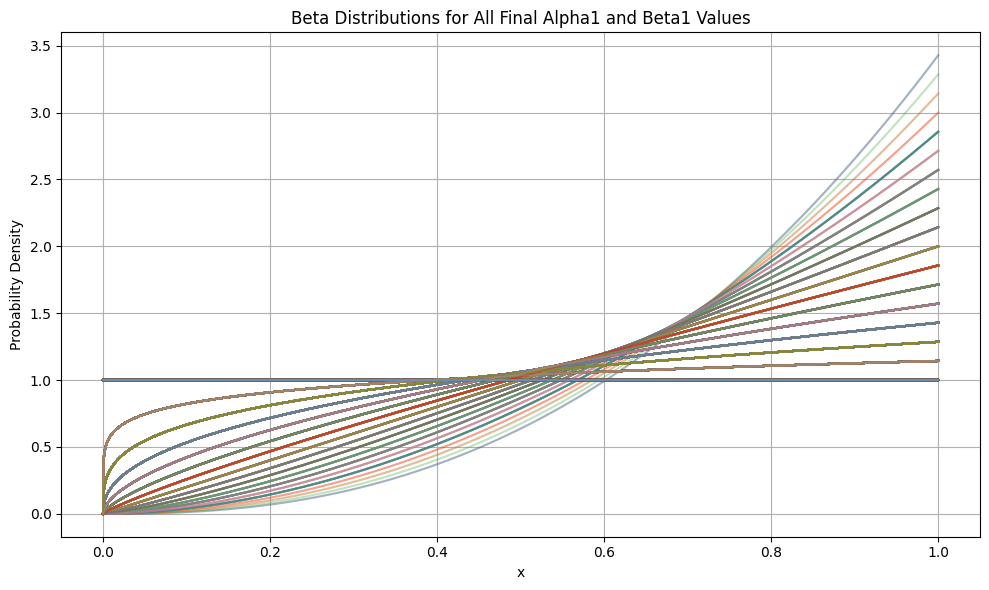

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import pandas as pd

# Load the DataFrame (already created from your previous results)
# If you need to load it again, use: df = pd.read_csv(PATH)

# Extract final alpha1 and beta1 values
alpha_values = df['final_alpha1'].values
beta_values = df['final_beta1'].values

# Create a plot to overlay multiple Beta distributions
x = np.linspace(0, 1, 1000)  # Values between 0 and 1 for Beta distribution
plt.figure(figsize=(10, 6))

# Plot each Beta distribution for the final alpha1 and beta1
for alpha, beta_param in zip(alpha_values, beta_values):
    y = beta.pdf(x, alpha, beta_param)
    plt.plot(x, y, label=f"α={alpha:.2f}, β={beta_param:.2f}", alpha=0.3)  # Add transparency for overlapping plots

# Customize the plot
plt.title('Beta Distributions for All Final Alpha1 and Beta1 Values')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
